In [1]:
"""
Aim of the code is to fit line emission under LTE conditions.
Fits center,temperature, column density, turbulent velocity.
MCMC Fitting of line emission in CO isotopologues
Code written by F. Alarcon
"""

import collision_cross_section	as ccs				# auxiliar quantities
import help_functions as hf					# finding maximum
from constants import *

from multiprocessing import Pool
import numpy as np
import scipy as sp
from scipy.integrate import quad
import pyfits as pf
import matplotlib.pyplot as plt
import os
import math
import sys
from astropy.convolution import Gaussian2DKernel, convolve_fft
import astropy.units as u
import astropy.constants as const
from astropy.analytic_functions import blackbody_nu
import pymc3 as pm


# constants in cgs units
h = const.h.cgs.value
c = const.c.cgs.value
k = const.k_B.cgs.value
mp = const.m_p.cgs.value

/usr/local/anaconda/lib/python2.7/site-packages/pyfits/__init__.py:22: PyFITSDeprecationWarning: PyFITS is deprecated, please use astropy.io.fits
  PyFITSDeprecationWarning)  # noqa
/usr/local/anaconda/lib/python2.7/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [3]:
def datafits(namefile):
    """
    Open a FITS image and return datacube and header, namefile without '.fits'
    """
    datacube = pf.open(namefile + '.fits')[0].data
    hdr = pf.open(namefile + '.fits')[0].header
    return datacube, hdr


def bbody(T,nu):
    """
    Blackbody flux for a given temperature and frequency erg / (cm2 Hz s sr) (cgs system)
    """
    bb = 2*h*nu**3/(c**2*(sp.exp(h*nu/(k*T))-1.))
    #return blackbody_nu(nu, T).cgs.value
    return bb


def phi(t,nu,nu0,vturb,angle, m):
    """
    Returns the normalized line profile.
    t: Temperature.
    nu: Array of frecuencies to sample teh line profile.
    nu0: Center of line emission.
    vturb: Turbulent velocity or dispersion velocity along the line of sight(cgs system).
    m: Molecule mass.
    """
    #pa = (-20+90+angle)*math.pi/180.0  #-20 is the PA from east of north, and 90 to get the semi-minor axis
    #Q = 1
    #shear = (Q*math.sin(incli)**2)*(math.tan(incli)**2)*math.sin(2*pa)**2
    #deltav = (nu0/c)*math.sqrt(k*t/m + vturb**2 )*(1+shear)**(0.5) 
    #deltav = (nu0/c)*math.sqrt(2*k*t/m + vturb**2 )
    #phi0 = deltav*math.sqrt(math.pi)
    #gauss=sp.exp(-((nu-nu0)**2.0)/(deltav**2.0))
 
    deltav = (nu0/c)*math.sqrt(k*t/m + vturb**2 )
    phi0 = deltav*math.sqrt(2*math.pi)
    gauss=sp.exp(-((nu-nu0)**2.0)/(2*(deltav**2.0)))
    gauss /= phi0
    return gauss


def tau(t,nu,nu0,nco,vturb,angle,iso=12):
    """
    Returns the optical depth for a certain CO isotopologue.
    t: Temperature.
    nu: Array of frecuencies to sample the line profile.
    nu0: Center of line emission.
    nco: Column density for excited state
    vturb: Turbulent velocity or dispersion velocity along the line of sight(cgs system).
    iso: Isotopologue Number.
    """
    sigma = ccs.cross_section("13CO")
    m = ccs.cross_section("13CO")
    if iso==12:
        sigma = ccs.cross_section("12CO")
        m = ccs.molecular_mass("12CO")
    elif iso==13:
        sigma = ccs.cross_section("13CO")
        m = ccs.molecular_mass("13CO")
    elif iso==18:
        sigma = ccs.cross_section("C18O")
        m = ccs.molecular_mass("C18O")
    #m*=mp
    return (sp.exp(h*nu/(k*t))-1)*nco*sigma*phi(t,nu,nu0,vturb,angle, m)/math.cos(incli)
    #return nco*sigma*phi(t,nu,nu0,vturb,angle, m)/math.cos(incli)


def intensity(nu, T, nu0, nco, vturb, angle, hdr, iso=12):
    """
    Solution to radiative transfer equation
    """
    if iso==13:
        nco*= 1e-2
    if iso==18:
        nco*=1.7e-3
    pix_deg = abs(hdr['CDELT1'])
    pix_rad = pix_deg*sp.pi/180.
    bminaxis =  pix_deg
    bmajaxis = pix_deg
    scaleaux = (u.erg/(u.s*u.cm*u.Hz*u.cm*u.sr)).to(u.Jy/(u.deg*u.deg)) #cgs to JY/deg^2
    scaling = scaleaux*pix_deg**2   ##cgs to Jy/pix^2
    bbody = 2*h*nu**3/(c**2*(sp.exp(h*nu/(k*T))-1.))
    sigma = ccs.cross_section("13CO")
    m = ccs.cross_section("13CO")
    if iso==12:
        sigma = ccs.cross_section("12CO")
        m = ccs.molecular_mass("12CO")
    elif iso==13:
        sigma = ccs.cross_section("13CO")
        m = ccs.molecular_mass("13CO")
    elif iso==18:
        sigma = ccs.cross_section("C18O")
        m = ccs.molecular_mass("C18O")
    #deltav = (nu0/c)*math.sqrt(k*T/m + vturb**2 )
    deltav = (nu0/c)*vturb
    phi0 = deltav*sp.sqrt(2*math.pi)
    gauss=sp.exp(-((nu-nu0)**2.0)/(2*(deltav**2.0)))
    gauss /= phi0
    phi = gauss
    opt_depth = (sp.exp(h*nu/(k*T))-1)*nco*sigma*phi/math.cos(incli)
    blackbody = bbody*(1.0-sp.exp(-opt_depth))*scaling
    return  blackbody


def intensity_continuum(nu, T, nu0, alpha, nco, vturb, angle, i0, hdr,iso=12):
    """
    Solution to radiative transfer equation with continuum
    """
    pix_deg = abs(hdr['CDELT1'])
    pix_rad = pix_deg*sp.pi/180.
    bminaxis =  pix_deg  #arcsec
    bmajaxis = pix_deg  #arcsec,
    scaleaux = (u.erg/(u.s*u.cm*u.Hz*u.cm*u.sr)).to(u.Jy/(u.deg*u.deg)) #cgs to JY/deg^2
    scaling = scaleaux*pix_deg**2
    if iso==13:
        nco/= 80.
    if iso==18:
        nco/=500.
    deltav = (nu0/c)*vturb
    phi0 = deltav*sp.sqrt(2*math.pi)
    gauss=sp.exp(-((nu-nu0)**2.0)/(2*(deltav**2.0)))
    gauss /= phi0
    phi = gauss
    opt_depth = (sp.exp(h*nu/(k*T))-1)*nco*sigma*phi/math.cos(incli)
    blackbody = bbody*(1.0-sp.exp(-opt_depth))*scaling
    cont = i0*sp.exp(-opt_depth)*(nu/nu0)**alpha
    return  blackbody + cont 


def intensity_dust_err(nu, nu0, T, alpha, i0, nco, vturb, angle, datos, hdr,iso=12):
    """
    Chi squared of data with fit of spectral line, considering continuum absorption from midplane.
    """
    model, tau0, taus = intensity_continuum(nu, T, nu0, alpha, nco, vturb, angle, i0, hdr, iso)
    aux = (datos-model)**2
    median = sp.median(datos)
    chi = sp.sum(aux/median**2)
    return chi*1e3

def partition(inputfile):
    """
    Return arrays with energy and weights of molecule from inputfile.
    inputfile: file with data for molecule.
    """
    level = sp.arange(1,42)
    energies = sp.zeros(41)
    gs = sp.zeros(41)
    
    arch = open(inputfile,'r')
    
    arch.readline()
    arch.readline()
    arch.readline()
    arch.readline()
    arch.readline()
    arch.readline()
    arch.readline()
    
    for i in range(41):
        l = arch.readline().split()
        level[i] = int(l[0])
        energies[i] = float(l[1])
        gs[i] = float(l[2])
    
    energies *= 0.000123986  #cm^-1 to eV
    energies *= u.eV.to(u.erg)  #eV to erg

    return energies, gs


def Part(energies, gs,T):
    """
    Returns Q
    T: Temperature
    """
    return sp.sum(gs*sp.exp(-energies/(k*T)))


def intensity_dust_err(nu, nu0, T, alpha, i0, nco, vturb, angle, datos, hdr,rms,iso=12):
    """
    Chi squared of data with fit of spectral line, considering continuum absorption from midplane.
    """
    model, tau0, taus = intensity_continuum(nu, T, nu0, alpha, nco, vturb, angle, i0, hdr, iso)
    aux = (datos-model)**2
    median = sp.median(datos)
    #chi = sp.sum(aux/median**2)
    chi = sp.sum(aux)/rms**2
    return chi#*1e3


def intensity_err(nu, nu0, T, nco, vturb, angle, datos, hdr,rms, iso=12):
    """
    Chi squared of data with fit of spectral line, both normalized.
    """
    model ,tau0, taus = intensity(nu, T, nu0, nco, vturb, angle, hdr, iso)
    aux = (datos-model)**2
    median = sp.median(datos)
    chi = sp.sum(aux/median**2)
    chi = sp.sum(aux)/rms**2
    return chi


def Convolv(cubo, head, Beam=0.25):
    resol = abs(head['CDELT1'])*3600
    stdev = Beam / (2 * sp.sqrt (2 * sp.log(2)))
    stdev /= resol
    x_size = int(8*stdev + 1.)

    print 'convolution with gaussian'
    print '\tbeam '+str(Beam)+' arcsec'
    print '\tbeam '+str(stdev)+' pixels'

    # circular Gaussian
    beam = Gaussian2DKernel (stddev = stdev, x_size = x_size, y_size = x_size,
                             model ='integrate')
    smooth =  np.zeros((256, 256))
    smooth += convolve_fft(cubo[:,:], beam)
    print '\tsmoothed'
    return smooth



Paradigma 1: Paralelizar ajustes de distintos espectros en distintos cores

In [4]:
"""
Fits a temperature profile, turbulent velocity and column density
using three CO isotopologues lines with iminuit package.
"""
cont = True
r = 80   # radius in pixels units where to make the fit
# CO isotopologue, it could be 12,13,18
iso = 13
Convolve = False
Beam = 0.25                                                         #Only used if Convolve=True, size of beam in arcsec.

tag_nco = '/Users/falarcon/Desktop/Tesis/Line_fitting/test_fo/'           #path with the molecule input files.
g_u = 7                                                             #Degeneracy of state
Z = tag_nco + 'molecule_13c16o.inp'                                 #File with info of molecular transitions.
en, gs = partition(Z) 
incli = 30.*sp.pi/180.                                               #Inclination of disk in degrees.
path = '/Users/falarcon/Desktop/Tesis/Line_fitting/fo_pardisk/'           # Path to FITS files to fit.
image = path + 'image_13co32_nodust_o0_i150.00_phi90.00_PA-24.00'  #Fits File without the .fits
ncores = 2                                                          #Number of cores for parallel running.

if iso==12:
    sigma = ccs.cross_section("12CO")
    m = ccs.molecular_mass("12CO")
elif iso==13:
    sigma = ccs.cross_section("13CO")
    m = ccs.molecular_mass("13CO")
elif iso==18:
    sigma = ccs.cross_section("C18O")
    m = ccs.molecular_mass("C18O")
print('Opening FITS images and fitting functions')

#  Isotopologue image and centroid map
cubo, head = datafits(image)

dnu = head['CDELT3']
len_nu = head['NAXIS3']
nui = head['CRVAL3']- head['CRPIX3']*dnu
nuf = nui + (len_nu-1)*dnu

nu = sp.linspace(nui, nuf, len_nu)
nu0 = sp.mean(nu)

#Gaussian Convolution
if False:
    resol = abs(head['CDELT1'])*3600
    stdev = Beam / (2 * sp.sqrt (2 * sp.log(2)))
    stdev /= resol
    x_size = int(8*stdev + 1.)

    print 'convolution with gaussian'
    print '\tbeam '+str(Beam)+' arcsec'
    print '\tbeam '+str(stdev)+' pixels'

    # circular Gaussian
    beam = Gaussian2DKernel (stddev = stdev, x_size = x_size, y_size = x_size,
                             model ='integrate')
    smooth =  np.zeros((80, 256, 256))
    for k in range(80):
        smooth[k, :,:] += convolve_fft(cubo[k,:,:], beam)
    print '\tsmoothed'
    cubo = smooth



cubomax = cubo.max()

stderr = sp.std(cubo)
alpha = 2.3
i0 = 0.0   # continuum guess
angle = 24.*sp.pi/180.   # PA, not used for fitting.
ndim = head['NAXIS1']
Temperature = sp.zeros((ndim,ndim,6))
tau0 = sp.zeros((ndim,ndim))
Denscol = sp.zeros((ndim,ndim,6))
Turbvel = sp.zeros((ndim,ndim,6))
vel_cen = sp.zeros((ndim,ndim,6))
dust = sp.zeros((ndim,ndim,cubo.shape[0]))
model = sp.zeros((ndim,ndim,cubo.shape[0]))
mom2 = sp.zeros((ndim,ndim))
velocities = sp.linspace(sp.around(((nu0-nui)*c*1e-5/nu0),1),sp.around((nu0-nuf)*c*1e-5/nu0),len_nu)



Opening FITS images and fitting functions


In [5]:
i = 179
j = 186
data = cubo[:,i,j]
data_aux = cubo[:,i,j]

datamax = data.max()
ruido = sp.random.normal(scale=datamax*0.1,size=len(data))
data = data+ruido
if (i-int(ndim/2.))**2 + (j-int(ndim/2.))**2 > r**2 or 0.4*cubomax>datamax:
    print 'Ups'

m0 = sp.integrate.simps(data,nu)
m1 = sp.integrate.simps(velocities*data, nu)/m0
mom2[i,j] = sp.integrate.simps(data*(velocities-m1)**2, nu)*1000/m0

datamin = max(data.min(),0)
data1 = data -datamin
centroid = (nu*(cubo[:,i,j]-datamin)).sum()/(cubo[:,i,j]-datamin).sum()

i0 = datamin
if i0==0:
    i0=1e-10
i0_lim=(0.5*i0,1.2*i0)

r_ij = sp.sqrt((i-128)**2 +(j-128)**2)
rho_ij = r_ij/sp.cos(incli)

print r_ij

if rho_ij<30:
    temp_0 = 70
    tlim = (10,200)
else:
    temp_0 = 70 * (r_ij / 30.)**(-0.5)
    tlim = (10,120)
vels = (nu-nu0)*3e5/nu0
velg = vels[data==data.max()][0]

noise = data[(velocities<velg-1) | (velocities>velg+1.)]
rms = np.sqrt(sp.sum(noise**2)/float(len(noise)))



Ups
55.31726674375732


In [9]:
line_model = pm.Model()
        
with line_model:
                   
    var = ['Temp','nu_c','log(N_CO)','v_turb']

        # Priors for unknown model parameters
    Temp = pm.TruncatedNormal('Temp', mu=temp_0, sd=5, lower=tlim[0], upper=tlim[1])
    nu_c = pm.TruncatedNormal('nu_c', mu=centroid, sd=abs(dnu)/10., lower=centroid-0.5*abs(dnu), upper=centroid+0.5*abs(dnu))
    NCO = pm.Uniform('log(N_CO)', lower=10, upper=24)
    v_turb = pm.Uniform('v_turb', lower=sp.sqrt(k*tlim[0]/m), upper=300000)
    
        # Expected value of outcome
    predict = intensity(nu, Temp, nu_c, 10**NCO, v_turb, angle, head, iso)

        # Likelihood (sampling distribution) of observations
    Y_obs = pm.Normal('Y_obs', mu=predict, sd=rms, observed=data)
    step = pm.NUTS()

    st = {'Temp':temp_0,
         'nu_c':centroid,
         'log(N_CO)':20,
         'v_turb':20000}
    
    trace = pm.sample(10000,tune=1000,cores=2,step=step,start=st)

    stats = pm.summary(trace)
        
    mean_pars = [stats['mean'][x] for x in var]
    hpd_2_5 = [stats['hpd_2.5'][x] for x in var]
    hpd_97_5 = [stats['hpd_97.5'][x] for x in var]
    var_std = [stats['sd'][x] for x in var]
    medians_pars = [sp.median(trace[x]) for x in var]
    Map = [float(pm.find_MAP(model=line_model)[x]) for x in var]
    fit = mean_pars
    model = intensity(nu, fit[0], fit[1], 10**fit[2], fit[3], angle, head, iso)

Temperature[i,j,:] = sp.array([fit[0],var_std[0],medians_pars[0],Map[0],hpd_2_5[0],hpd_2_5[0]])
Denscol[i,j,:] = sp.array([10**fit[2],10**fit[2]*sp.log(10)*var_std[2],10**medians_pars[2],10**Map[2],10**hpd_2_5[2],10**hpd_2_5[2]])
Turbvel[i,j,:] = sp.sqrt(((sp.array([fit[3],var_std[3],medians_pars[3],Map[3],hpd_2_5[3],hpd_2_5[3]]))**2 - k*fit[0]/m))*1e-5
aux_nu = sp.array([fit[1],var_std[1],medians_pars[1],Map[1],hpd_2_5[1],hpd_2_5[1]])
vel_cen[i,j,:] = sp.around(((nu0-aux_nu)*c*1e-5/nu0))

Multiprocess sampling (2 chains in 2 jobs)
NUTS: [v_turb, log(N_CO), nu_c, Temp]
The acceptance probability does not match the target. It is 0.6265872951996658, but should be close to 0.8. Try to increase the number of tuning steps.
There were 33 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.4202695040748606, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 10% for some parameters.
logp = nan, ||grad|| = 0: 100%|██████████| 3/3 [00:00<00:00, 437.44it/s]
logp = nan, ||grad|| = 0: 100%|██████████| 3/3 [00:00<00:00, 475.04it/s]
logp = nan, ||grad|| = 0: 100%|██████████| 3/3 [00:00<00:00, 495.12it/s]
logp = nan, ||grad|| = 0: 100%|██████████| 3/3 [00:00<00:00, 452.69it/s]
/usr/local/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:40: ComplexWarning: Casting complex values to real discards the imaginary part


In [10]:
stats

,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
Temp,4.362881e+01,7.278009,0.302439,3.185368e+01,5.619283e+01,445.213117,1.001472
nu_c,3.305876e+11,7930.035528,184.960930,3.305876e+11,3.305876e+11,1731.328716,1.000001
log(N_CO),1.740737e+01,0.476691,0.015301,1.703133e+01,1.845732e+01,936.578451,0.999951
v_turb,1.111440e+04,2087.219657,67.788536,6.340719e+03,1.417809e+04,890.781532,1.000468


v_turb :  0.0
vel_cen :  [     0. 299792.      0.      0.      0.      0.]


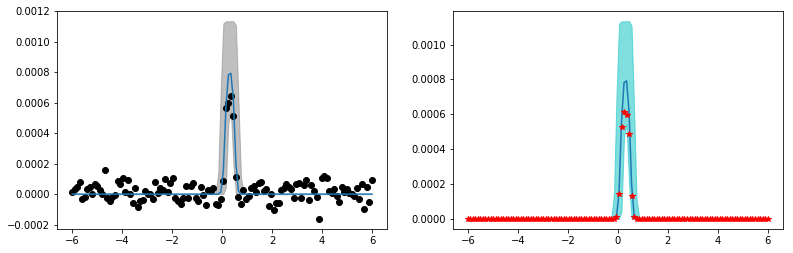

In [11]:
plt.figure(figsize=(13,4))
print 'v_turb : ',Turbvel[i,j,0]
print 'vel_cen : ',vel_cen[i,j,:]

model_l = intensity(nu, hpd_2_5[0], hpd_2_5[1], 10**hpd_2_5[2], hpd_2_5[3], angle, head, iso)
model_u = intensity(nu, hpd_97_5[0], hpd_97_5[1], 10**hpd_97_5[2], hpd_97_5[3], angle, head, iso)

plt.subplot(121)

dv = velocities[1]-velocities[0]
#plt.bar(velocities,data,fill=False,width=dv)
plt.plot(velocities,data,'ko')
plt.plot(velocities,model)
plt.fill_between(velocities, model_l, model_u, color='0.5', alpha=0.5)

plt.subplot(122)

plt.plot(velocities,model)
plt.plot(velocities,data_aux,'r*')
plt.fill_between(velocities, model_l, model_u, color='c', alpha=0.5)

/usr/local/anaconda/lib/python2.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval
/usr/local/anaconda/lib/python2.7/site-packages/matplotlib/contour.py:1004: UserWarning: The following kwargs were not used by contour: 'color', 'label'
  s)


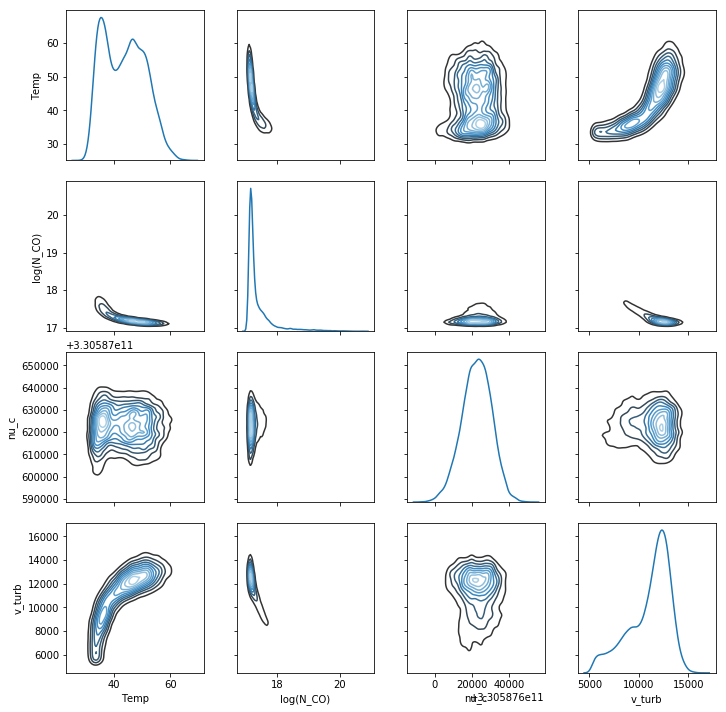

In [12]:
import seaborn as sns

import pandas as pd
df = pd.DataFrame({'Temp':trace['Temp'],'nu_c':trace['nu_c'],'log(N_CO)':trace['log(N_CO)'],'v_turb':trace['v_turb']})
g = sns.PairGrid(df,despine=False,diag_sharey=False)
g.map_lower(sns.kdeplot, cmap="Blues_d")
g.map_upper(sns.kdeplot, cmap="Blues_d")
g.map_diag(sns.kdeplot)

In [11]:
"""
Fits a temperature profile, turbulent velocity and column density
using three CO isotopologues lines with iminuit package.
"""
cont = False
r = 17   # radius in pixels units where to make the fit
# CO isotopologue, it could be 12,13,18
iso = 13
Convolve = False
Beam = 0.25                                                         #Only used if Convolve=True, size of beam in arcsec.

tag_nco = '/Users/falarcon/Desktop/Tesis/Line_fitting/test_fo/'                                 #path with the molecule input files.
g_u = 7                                                             #Degeneracy of state
Z = tag_nco + 'molecule_13c16o.inp'                                 #File with info of molecular transitions.
en, gs = partition(Z) 
incli = 0.*sp.pi/180.                                               #Inclination of disk in degrees.
path = '/Users/falarcon/Desktop/Tesis/Line_fitting/fo_pardisk/'                            # Path to FITS files to fit.
image = path + 'image_13co32_nodust__o0_i180.00_phi90.00_PA-24.00'  #Fits File without the .fits
ncores = 4                                                        #Number of cores for parallel running.

print('Opening FITS images and fitting functions')

#  Isotopologue image and centroid map
cubo, head = datafits(image)

dnu = head['CDELT3']
len_nu = head['NAXIS3']
nui = head['CRVAL3']- head['CRPIX3']*dnu
nuf = nui + (len_nu-1)*dnu

nu = sp.linspace(nui, nuf, len_nu)
nu0 = sp.mean(nu)

#Gaussian Convolution
if False:
    resol = abs(head['CDELT1'])*3600
    stdev = Beam / (2 * sp.sqrt (2 * sp.log(2)))
    stdev /= resol
    x_size = int(8*stdev + 1.)

    print 'convolution with gaussian'
    print '\tbeam '+str(Beam)+' arcsec'
    print '\tbeam '+str(stdev)+' pixels'

    # circular Gaussian
    beam = Gaussian2DKernel (stddev = stdev, x_size = x_size, y_size = x_size,
                             model ='integrate')
    smooth =  np.zeros((80, 256, 256))
    for k in range(80):
        smooth[k, :,:] += convolve_fft(cubo[k,:,:], beam)
    print '\tsmoothed'
    cubo = smooth



cubomax = cubo.max()

stderr = sp.std(cubo)
alpha = 2.3
i0 = 0.0   # continuum guess
angle = 24.*sp.pi/180.   # PA, not used for fitting.
ndim = head['NAXIS1']
Temperature = sp.zeros((ndim,ndim,6))
tau0 = sp.zeros((ndim,ndim))
Denscol = sp.zeros((ndim,ndim,6))
Turbvel = sp.zeros((ndim,ndim,6))
vel_cen = sp.zeros((ndim,ndim,6))
dust = sp.zeros((ndim,ndim,cubo.shape[0]))
model = sp.zeros((ndim,ndim,cubo.shape[0]))
mom2 = sp.zeros((ndim,ndim))
velocities = sp.linspace(sp.around(((nu0-nui)*c*1e-5/nu0),1),sp.around((nu0-nuf)*c*1e-5/nu0),len_nu)

def parspar(n):
    i = n/ndim
    j = n%ndim
    data = cubo[:,i,j]
    datamax = data.max()
    noise_level = 0
    noise_g = sp.random.normal(scale=noise_level,size=len(data))
    data = data+noise_g
    if (i-int(ndim/2.))**2 + (j-int(ndim/2.))**2 > r**2 or 0.4*cubomax>datamax:
        return [None]

    print i,j

    m0 = sp.integrate.simps(data,nu)
    m1 = sp.integrate.simps(velocities*data, nu)/m0
    mom2[i,j] = sp.integrate.simps(data*(velocities-m1)**2, nu)*1000/m0


    datamin = data.min()
    data1 = data -data.min()
    centroid = (nu*(cubo[:,i,j]-datamin)).sum()/(cubo[:,i,j]-datamin).sum()

    i0 = datamin
    if i0==0:
        i0=1e-10
    i0_lim=(0.5*i0,1.2*i0)


    r_ij = sp.sqrt((i-128)**2 +(j-128)**2)
    rho_ij = r_ij/sp.cos(incli)

    if rho_ij<30:
        temp_0 = 70
        tlim = (10,200)
    else:
        temp_0 = 70 * (r_ij / 30.)**(-0.5)
        tlim = (10,120)
    vels = (nu-nu0)*3e5/nu0
    velg = vels[data==data.max()][0]

    noise = data[(velocities<velg-1) | (velocities>velg+1.)]
    rms = np.sqrt(sp.sum(noise**2)/float(len(noise)))

## Cont=True Fit lines considering the presence of continuum.
    if cont:
        line_model = pm.Model()
    
        with line_model:
        
            var = ['Temp','nu_c','log(N_CO)','v_turb','Continuum']

# Priors for unknown model parameters
            Temp = pm.TruncatedNormal('Temp', mu=temp_0, sd=5, lower=tlim[0], upper=tlim[1])
            nu_c = pm.TruncatedNormal('nu_c', mu=centroid, sd=abs(dnu)/10., lower=centroid-0.5*abs(dnu), upper=centroid+0.5*abs(dnu))
            NCO = pm.Uniform('log(N_CO)', lower=10, upper=24)
            v_turb = pm.Uniform('v_turb', lower=sp.sqrt(k*tlim[0]/m), upper=300000)  ## This is really broadening in velocity space, not turbulent vel.
            i_0 = pm.TruncatedNormal('Continuum', mu=i0, sd=5, lower=i0_lim[0], upper=i0_lim[1])
    
    # Expected value of outcome
            predict = intensity_continuum(nu, Temp, nu_c, alpha, 10**NCO, v_turb, angle, i_0, head, iso)
    
    # Likelihood (sampling distribution) of observations
            Y_obs = pm.Normal('Y_obs', mu=predict, sd=rms, observed=data)
            step = pm.NUTS()
    
            st = {'Temp':temp_0,
                'nu_c':centroid,
                'log(N_CO)':20,
                'v_turb':20000,
                'Continuum':i0}

            trace = pm.sample(5000,tune=1000,cores=2,step=step,start=st)

            stats = pm.summary(trace)

            mean_pars = [stats['mean'][x] for x in var]
            hpd_2_5 = [stats['hpd_2.5'][x] for x in var]
            hpd_97_5 = [stats['hpd_2.5'][x] for x in var]
            var_std = [stats['sd'][x] for x in var]
            medians_pars = [sp.median(trace[x]) for x in var]
            Map = [float(pm.find_MAP(model=line_model)[x]) for x in var]
            fit = mean_pars
            model = intensity_continuum(nu, fit[0], fit[1],alpha, 10**fit[2], fit[3], angle,fit[4], head, iso)

#dust[i,j] = fit[3]*sp.exp(-tau(fit[0],nu,fit[4],fit[2],fit[1],angle, iso))*(nu/nu0)**alpha


    else:
        line_model = pm.Model()
    
        with line_model:
        
            var = ['Temp','nu_c','log(N_CO)','v_turb']
            
            # Priors for unknown model parameters
            Temp = pm.TruncatedNormal('Temp', mu=temp_0, sd=5, lower=tlim[0], upper=tlim[1])
            nu_c = pm.TruncatedNormal('nu_c', mu=centroid, sd=abs(dnu)/10., lower=centroid-0.5*abs(dnu), upper=centroid+0.5*abs(dnu))
            NCO = pm.Uniform('log(N_CO)', lower=10, upper=24)
            v_turb = pm.Uniform('v_turb', lower=sp.sqrt(k*tlim[0]/m), upper=300000) ## This is really broadening in velocity space, not turbulent vel.
            
            # Expected value of outcome
            predict = intensity(nu, Temp, nu_c, 10**NCO, v_turb, angle, head, iso)
            
            # Likelihood (sampling distribution) of observations
            Y_obs = pm.Normal('Y_obs', mu=predict, sd=rms, observed=data)
            step = pm.NUTS()
            
            st = {'Temp':temp_0,
                'nu_c':centroid,
                'log(N_CO)':20,
                'v_turb':20000}
        
            trace = pm.sample(5000,tune=1000,cores=2,step=step,start=st)
            
            stats = pm.summary(trace)
            
            mean_pars = [stats['mean'][x] for x in var]
            hpd_2_5 = [stats['hpd_2.5'][x] for x in var]
            hpd_97_5 = [stats['hpd_2.5'][x] for x in var]
            var_std = [stats['sd'][x] for x in var]
            medians_pars = [sp.median(trace[x]) for x in var]
            Map = [float(pm.find_MAP(model=line_model)[x]) for x in var]
            fit = mean_pars
            model = intensity(nu, fit[0], fit[1], 10**fit[2], fit[3], angle, head, iso)

    Temperature[i,j,:] = sp.array([fit[0],var_std[0],medians_pars[0],Map[0],hpd_2_5[0],hpd_2_5[0]])
    Denscol[i,j,:] = sp.array([10**fit[2],10**fit[2]*sp.log(10)*var_std[2],10**medians_pars[2],10**Map[2],10**hpd_2_5[2],10**hpd_2_5[2]])
    Turbvel[i,j,:] = sp.sqrt(((sp.array([fit[3],var_std[3],medians_pars[3],Map[3],hpd_2_5[3],hpd_2_5[3]]))**2 - k*fit[0]/m))*1e-5
    aux_nu = sp.array([fit[1],var_std[1],medians_pars[1],Map[1],hpd_2_5[1],hpd_2_5[1]])
    vel_cen[i,j,:] = sp.around(((nu0-aux_nu)*c*1e-5/nu0))
    return [i,j,Temperature[i,j,:], Denscol[i,j,:], Turbvel[i,j,:],vel_cen[i,j,:]]


p = Pool(ncores)
todo = p.map(parspar, range(cubo[0,:,:].size))
todo = sp.array(todo)
#todo = todo[todo!=None]
for ls in todo:
    if len(ls)!=6:
        continue
    i = ls[0]
    j = ls[1]
    Temperature[i,j,:] = ls[2]
    Denscol[i,j,:] = ls[3]
    Turbvel[i,j,:] = ls[4]
    vel_cen[i,j,:] = ls[5]


# Parameter error (confidence intervals)
#errmodel= sp.array(errmodel)
#model = sp.array(model)
#model = sp.swapaxes(model, 0,1)
#model = sp.swapaxes(model,0,2)
print('Calculated Fits')
#model = sp.nan_to_num(model)
#dust = sp.nan_to_num(dust)
Denscol = sp.nan_to_num(Denscol)
Turbvel = sp.nan_to_num(Turbvel)
Temperature = sp.nan_to_num(Temperature)
vel_cen = sp.nan_to_num(vel_cen)
#tau0 = sp.nan_to_num(tau0)

if Convolve:
    Denscol = Convolv(Denscol, head)
    Temperature = Convolv(Temperature, head)
    Turbvel = Convolv(Turbvel, head)
    mom2 = Convolv(mom2, head)

#r1 = pf.PrimaryHDU(model)
r2 = pf.PrimaryHDU(Temperature)
r3 = pf.PrimaryHDU(Turbvel)
r4 = pf.PrimaryHDU(Denscol)
#r5 = pf.PrimaryHDU(errmodel)
#r6 = pf.PrimaryHDU(tau0)
r9 = pf.PrimaryHDU(mom2)
#r10 = pf.PrimaryHDU(dust)
head1 = head
head2 = head
head3 = head
head4 = head
#r1.header = head
r2.header = head1;
head1['BUNIT'] = 'K'
head2['BUNIT'] = 'cm/s'
head2['BTYPE'] = 'Velocity'
head3['BUNIT'] = 'm-2'
head3['BTYPE'] = 'Column Density'
head3['BUNIT'] = 'cm'
head4['BTYPE'] = 'Optical Depth'
r3.header = head2
r4.header = head3
#r5.header = head
#r6.header = head4
r9.header = head2
#r10.header = head

## Path where FITS files are saved.
inputimage = '/Users/falarcon/Desktop/Line_fitting/fo_pardisk/sims_' + str(iso)
out1 = inputimage + '_model.fits'
out2 = inputimage + '_Temp.fits'
out3 = inputimage + '_v_turb.fits'
out4 = inputimage + '_NCO.fits'
out6 = inputimage + '_tau_nu0.fits'
out5 = inputimage + '_errfit.fits'
out9 = inputimage + '_mom2.fits'
out10 = inputimage + '_dust.fits'
print('Writing images')
#r1.writeto(out1, clobber=True)
r2.writeto(out2, clobber=True)
r3.writeto(out3, clobber=True)
r4.writeto(out4, clobber=True)
#r5.writeto(out5, clobber=True)
#r6.writeto(out6, clobber=True)
r9.writeto(out9, clobber=True)
#r10.writeto(out10, clobber=True)
#pf.writeto(out1, model, head, clobber=True)
pf.writeto(out2, Temperature, head1, clobber=True)
pf.writeto(out3, Turbvel, head2, clobber=True)
pf.writeto(out4, Denscol, head3, clobber=True)
#pf.writeto(out5, errmodel, head, clobber=True)
pf.writeto(out9, mom2, head2, clobber=True)
#pf.writeto(out6, tau0, head4, clobber=True)
#pf.writeto(out10, dust, head, clobber=True)



Opening FITS images and fitting functions
113 136
128 145
144 123


INFO (theano.gof.compilelock): Waiting for existing lock by process '52936' (I am process '52933')
INFO (theano.gof.compilelock): To manually release the lock, delete /Users/falarcon/.theano/compiledir_Darwin-17.7.0-x86_64-i386-64bit-i386-2.7.14-64/lock_dir
INFO (theano.gof.compilelock): Waiting for existing lock by process '52936' (I am process '52934')
INFO (theano.gof.compilelock): To manually release the lock, delete /Users/falarcon/.theano/compiledir_Darwin-17.7.0-x86_64-i386-64bit-i386-2.7.14-64/lock_dir
INFO (theano.gof.compilelock): Waiting for existing lock by process '52936' (I am process '52933')
INFO (theano.gof.compilelock): To manually release the lock, delete /Users/falarcon/.theano/compiledir_Darwin-17.7.0-x86_64-i386-64bit-i386-2.7.14-64/lock_dir
INFO (theano.gof.compilelock): Waiting for existing lock by process '52936' (I am process '52934')
INFO (theano.gof.compilelock): To manually release the lock, delete /Users/falarcon/.theano/compiledir_Darwin-17.7.0-x86_64-i38

116 140


logp = 756.95, ||grad|| = 244.31: 100%|██████████| 61/61 [00:00<00:00, 853.36it/s]         
logp = 756.95, ||grad|| = 244.31: 100%|██████████| 61/61 [00:00<00:00, 805.80it/s]         
INFO (theano.gof.compilelock): Waiting for existing lock by process '52936' (I am process '52933')
INFO (theano.gof.compilelock): To manually release the lock, delete /Users/falarcon/.theano/compiledir_Darwin-17.7.0-x86_64-i386-64bit-i386-2.7.14-64/lock_dir
logp = 756.95, ||grad|| = 244.31: 100%|██████████| 61/61 [00:00<00:00, 939.01it/s]         
/usr/local/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:200: ComplexWarning: Casting complex values to real discards the imaginary part


129 144


INFO (theano.gof.compilelock): Waiting for existing lock by process '52936' (I am process '52934')
INFO (theano.gof.compilelock): To manually release the lock, delete /Users/falarcon/.theano/compiledir_Darwin-17.7.0-x86_64-i386-64bit-i386-2.7.14-64/lock_dir
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [v_turb, log(N_CO), nu_c, Temp]
 52%|█████▏    | 3096/6000 [00:08<00:06, 448.03it/s]INFO (theano.gof.compilelock): Waiting for existing lock by process '52933' (I am process '52934')
INFO (theano.gof.compilelock): To manually release the lock, delete /Users/falarcon/.theano/compiledir_Darwin-17.7.0-x86_64-i386-64bit-i386-2.7.14-64/lock_dir
logp = 740.94, ||grad|| = 1,183.9: 100%|██████████| 51/51 [00:00<00:00, 771.40it/s]    
logp = 740.94, ||grad|| = 1,183.9: 100%|██████████| 51/51 [00:00<00:00, 1439.13it/s]   
100%|██████████| 6000/6000 [00:14<00:00, 425.22it/s]
logp = 740.94, ||grad|| = 1,183.9: 100%|██████████| 51/51 [00:00<00:00, 724.56it/s]    
logp = 740.94, ||grad|| = 1,183.9:

144 124


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [v_turb, log(N_CO), nu_c, Temp]
logp = 754.88, ||grad|| = 2.6335: 100%|██████████| 55/55 [00:00<00:00, 792.01it/s]    
logp = 754.88, ||grad|| = 2.6335: 100%|██████████| 55/55 [00:00<00:00, 806.61it/s]     
logp = 754.88, ||grad|| = 2.6335: 100%|██████████| 55/55 [00:00<00:00, 826.45it/s]    
logp = 754.88, ||grad|| = 2.6335: 100%|██████████| 55/55 [00:00<00:00, 727.18it/s]    
 93%|█████████▎| 5554/6000 [00:29<00:02, 198.09it/s]

119 142


100%|██████████| 6000/6000 [00:31<00:00, 190.48it/s]
INFO (theano.gof.compilelock): Waiting for existing lock by process '52936' (I am process '52933')
INFO (theano.gof.compilelock): To manually release the lock, delete /Users/falarcon/.theano/compiledir_Darwin-17.7.0-x86_64-i386-64bit-i386-2.7.14-64/lock_dir
INFO (theano.gof.compilelock): Waiting for existing lock by process '52936' (I am process '52933')
INFO (theano.gof.compilelock): To manually release the lock, delete /Users/falarcon/.theano/compiledir_Darwin-17.7.0-x86_64-i386-64bit-i386-2.7.14-64/lock_dir
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [v_turb, log(N_CO), nu_c, Temp]
 48%|████▊     | 2861/6000 [00:08<00:08, 358.05it/s]Multiprocess sampling (2 chains in 2 jobs)
NUTS: [v_turb, log(N_CO), nu_c, Temp]
100%|██████████| 6000/6000 [00:18<00:00, 331.73it/s]
logp = 861.14, ||grad|| = 149.88: 100%|██████████| 55/55 [00:00<00:00, 819.83it/s]            
logp = 861.14, ||grad|| = 149.88: 100%|██████████| 55/55 [00:00<00:00

130 144


logp = 748.49, ||grad|| = 0.0074089: 100%|██████████| 52/52 [00:00<00:00, 656.57it/s]   
INFO (theano.gof.compilelock): Waiting for existing lock by process '52933' (I am process '52934')
INFO (theano.gof.compilelock): To manually release the lock, delete /Users/falarcon/.theano/compiledir_Darwin-17.7.0-x86_64-i386-64bit-i386-2.7.14-64/lock_dir
logp = 750.48, ||grad|| = 405.41: 100%|██████████| 37/37 [00:00<00:00, 1055.24it/s]    
logp = 748.49, ||grad|| = 0.0074089: 100%|██████████| 52/52 [00:00<00:00, 419.58it/s]   


120 143


logp = 750.48, ||grad|| = 405.41: 100%|██████████| 37/37 [00:00<00:00, 1093.25it/s]   
logp = 750.48, ||grad|| = 405.41: 100%|██████████| 37/37 [00:00<00:00, 911.08it/s]    
logp = 750.48, ||grad|| = 405.41: 100%|██████████| 37/37 [00:00<00:00, 908.40it/s]    


144 125


INFO (theano.gof.compilelock): Waiting for existing lock by process '52934' (I am process '52936')
INFO (theano.gof.compilelock): To manually release the lock, delete /Users/falarcon/.theano/compiledir_Darwin-17.7.0-x86_64-i386-64bit-i386-2.7.14-64/lock_dir
INFO (theano.gof.compilelock): Waiting for existing lock by process '52934' (I am process '52933')
INFO (theano.gof.compilelock): To manually release the lock, delete /Users/falarcon/.theano/compiledir_Darwin-17.7.0-x86_64-i386-64bit-i386-2.7.14-64/lock_dir
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [v_turb, log(N_CO), nu_c, Temp]
100%|██████████| 6000/6000 [00:13<00:00, 430.50it/s]
INFO (theano.gof.compilelock): Waiting for existing lock by process '52936' (I am process '52933')
INFO (theano.gof.compilelock): To manually release the lock, delete /Users/falarcon/.theano/compiledir_Darwin-17.7.0-x86_64-i386-64bit-i386-2.7.14-64/lock_dir
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [v_turb, log(N_CO), nu_c, Temp]
 89%|██████

131 144


logp = 758.07, ||grad|| = 28.915: 100%|██████████| 58/58 [00:00<00:00, 758.29it/s]     
logp = 758.07, ||grad|| = 28.915: 100%|██████████| 58/58 [00:00<00:00, 766.54it/s]     
logp = 758.07, ||grad|| = 28.915: 100%|██████████| 58/58 [00:00<00:00, 866.41it/s]    


121 143


logp = 740.86, ||grad|| = 0.29879: 100%|██████████| 53/53 [00:00<00:00, 738.49it/s]    
INFO (theano.gof.compilelock): Waiting for existing lock by process '52934' (I am process '52936')
INFO (theano.gof.compilelock): To manually release the lock, delete /Users/falarcon/.theano/compiledir_Darwin-17.7.0-x86_64-i386-64bit-i386-2.7.14-64/lock_dir
logp = 740.86, ||grad|| = 0.29879: 100%|██████████| 53/53 [00:00<00:00, 805.20it/s]    
INFO (theano.gof.compilelock): Waiting for existing lock by process '52934' (I am process '52936')
INFO (theano.gof.compilelock): To manually release the lock, delete /Users/falarcon/.theano/compiledir_Darwin-17.7.0-x86_64-i386-64bit-i386-2.7.14-64/lock_dir
INFO (theano.gof.compilelock): Waiting for existing lock by process '52934' (I am process '52936')
INFO (theano.gof.compilelock): To manually release the lock, delete /Users/falarcon/.theano/compiledir_Darwin-17.7.0-x86_64-i386-64bit-i386-2.7.14-64/lock_dir
logp = 740.86, ||grad|| = 0.29879: 100%|██████████

144 126


 45%|████▌     | 2727/6000 [11:53<00:09, 341.92it/s] INFO (theano.gof.compilelock): Waiting for existing lock by process '52936' (I am process '52933')
INFO (theano.gof.compilelock): To manually release the lock, delete /Users/falarcon/.theano/compiledir_Darwin-17.7.0-x86_64-i386-64bit-i386-2.7.14-64/lock_dir
 69%|██████▊   | 4118/6000 [11:59<00:43, 43.54it/s] INFO (theano.gof.compilelock): Waiting for existing lock by process '52936' (I am process '52933')
INFO (theano.gof.compilelock): To manually release the lock, delete /Users/falarcon/.theano/compiledir_Darwin-17.7.0-x86_64-i386-64bit-i386-2.7.14-64/lock_dir
100%|██████████| 6000/6000 [12:10<00:00, 341.07it/s]
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [v_turb, log(N_CO), nu_c, Temp]
  0%|          | 0/6000 [00:00<?, ?it/s]INFO (theano.gof.compilelock): Waiting for existing lock by process '52936' (I am process '52933')
INFO (theano.gof.compilelock): To manually release the lock, delete /Users/falarcon/.theano/compiledir_Dar

132 144


logp = 750.04, ||grad|| = 3.1225: 100%|██████████| 54/54 [00:00<00:00, 723.01it/s]     
100%|██████████| 6000/6000 [22:45<00:00,  4.39it/s] 
logp = 750.04, ||grad|| = 3.1225: 100%|██████████| 54/54 [00:00<00:00, 819.12it/s]     
logp = 750.04, ||grad|| = 3.1225: 100%|██████████| 54/54 [00:00<00:00, 802.97it/s]    


123 144


INFO (theano.gof.compilelock): Waiting for existing lock by process '52936' (I am process '52934')
INFO (theano.gof.compilelock): To manually release the lock, delete /Users/falarcon/.theano/compiledir_Darwin-17.7.0-x86_64-i386-64bit-i386-2.7.14-64/lock_dir
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [v_turb, log(N_CO), nu_c, Temp]
 44%|████▍     | 2645/6000 [00:08<00:06, 479.34it/s]Multiprocess sampling (2 chains in 2 jobs)
NUTS: [v_turb, log(N_CO), nu_c, Temp]
100%|██████████| 6000/6000 [00:18<00:00, 323.34it/s]
logp = 860.99, ||grad|| = 2.5809: 100%|██████████| 54/54 [00:00<00:00, 772.67it/s]            
logp = 860.99, ||grad|| = 2.5809: 100%|██████████| 54/54 [00:00<00:00, 463.97it/s]           
logp = 860.99, ||grad|| = 2.5809: 100%|██████████| 54/54 [00:00<00:00, 783.43it/s]           
logp = -333.98, ||grad|| = 17.968: 100%|██████████| 36/36 [00:00<00:00, 542.54it/s]    
logp = 860.99, ||grad|| = 2.5809: 100%|██████████| 54/54 [00:00<00:00, 812.59it/s]            


144 129


logp = -333.98, ||grad|| = 17.968: 100%|██████████| 36/36 [00:00<00:00, 1082.93it/s]    
logp = 752.95, ||grad|| = 38.999: 100%|██████████| 56/56 [00:00<00:00, 1538.63it/s]    
logp = -333.98, ||grad|| = 17.968: 100%|██████████| 36/36 [00:00<00:00, 1166.07it/s]    
logp = 752.95, ||grad|| = 38.999: 100%|██████████| 56/56 [00:00<00:00, 1505.17it/s]    
logp = -333.98, ||grad|| = 17.968: 100%|██████████| 36/36 [00:00<00:00, 1047.79it/s]    


133 144


INFO (theano.gof.compilelock): Waiting for existing lock by process '52934' (I am process '52933')
INFO (theano.gof.compilelock): To manually release the lock, delete /Users/falarcon/.theano/compiledir_Darwin-17.7.0-x86_64-i386-64bit-i386-2.7.14-64/lock_dir
logp = 752.95, ||grad|| = 38.999: 100%|██████████| 56/56 [00:00<00:00, 788.96it/s]     
logp = 752.95, ||grad|| = 38.999: 100%|██████████| 56/56 [00:00<00:00, 791.00it/s]     


124 144


INFO (theano.gof.compilelock): Waiting for existing lock by process '52934' (I am process '52933')
INFO (theano.gof.compilelock): To manually release the lock, delete /Users/falarcon/.theano/compiledir_Darwin-17.7.0-x86_64-i386-64bit-i386-2.7.14-64/lock_dir
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [v_turb, log(N_CO), nu_c, Temp]
100%|██████████| 6000/6000 [00:12<00:00, 466.99it/s]
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [v_turb, log(N_CO), nu_c, Temp]
 89%|████████▉ | 5350/6000 [00:18<00:01, 502.88it/s]Multiprocess sampling (2 chains in 2 jobs)
NUTS: [v_turb, log(N_CO), nu_c, Temp]
100%|██████████| 6000/6000 [00:19<00:00, 303.64it/s]
logp = 758, ||grad|| = 1.9963: 100%|██████████| 54/54 [00:00<00:00, 750.64it/s]         
logp = 758, ||grad|| = 1.9963: 100%|██████████| 54/54 [00:00<00:00, 765.91it/s]         
logp = 758, ||grad|| = 1.9963: 100%|██████████| 54/54 [00:00<00:00, 455.66it/s]        
logp = 750.96, ||grad|| = 9.2296: 100%|██████████| 56/56 [00:00<00:00, 813.

134 143


logp = 750.96, ||grad|| = 9.2296: 100%|██████████| 56/56 [00:00<00:00, 791.22it/s]     
100%|██████████| 6000/6000 [00:34<00:00, 174.09it/s]
logp = 750.96, ||grad|| = 9.2296: 100%|██████████| 56/56 [00:00<00:00, 831.43it/s]    
logp = 750.96, ||grad|| = 9.2296: 100%|██████████| 56/56 [00:00<00:00, 471.77it/s]    


125 144


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [v_turb, log(N_CO), nu_c, Temp]
100%|██████████| 6000/6000 [00:16<00:00, 360.88it/s]
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [v_turb, log(N_CO), nu_c, Temp]
logp = 862.21, ||grad|| = 0.2109: 100%|██████████| 62/62 [00:00<00:00, 886.16it/s]            
100%|██████████| 6000/6000 [00:13<00:00, 440.40it/s]
logp = 862.21, ||grad|| = 0.2109: 100%|██████████| 62/62 [00:00<00:00, 535.74it/s]           
logp = 862.21, ||grad|| = 0.2109: 100%|██████████| 62/62 [00:00<00:00, 856.16it/s]           
logp = 751.82, ||grad|| = 0.0056671: 100%|██████████| 52/52 [00:00<00:00, 771.04it/s]  
logp = 862.21, ||grad|| = 0.2109: 100%|██████████| 62/62 [00:00<00:00, 502.01it/s]            


144 130


logp = 751.82, ||grad|| = 0.0056671: 100%|██████████| 52/52 [00:00<00:00, 735.68it/s]   
logp = 751.82, ||grad|| = 0.0056671: 100%|██████████| 52/52 [00:00<00:00, 764.73it/s]   
logp = 751.82, ||grad|| = 0.0056671: 100%|██████████| 52/52 [00:00<00:00, 788.33it/s]   
logp = 747.1, ||grad|| = 0.074698: 100%|██████████| 43/43 [00:00<00:00, 1290.13it/s]   


135 143


logp = 747.1, ||grad|| = 0.074698: 100%|██████████| 43/43 [00:00<00:00, 1259.33it/s]   
logp = 747.1, ||grad|| = 0.074698: 100%|██████████| 43/43 [00:00<00:00, 639.39it/s]    
INFO (theano.gof.compilelock): Waiting for existing lock by process '52934' (I am process '52933')
INFO (theano.gof.compilelock): To manually release the lock, delete /Users/falarcon/.theano/compiledir_Darwin-17.7.0-x86_64-i386-64bit-i386-2.7.14-64/lock_dir
logp = 747.1, ||grad|| = 0.074698: 100%|██████████| 43/43 [00:00<00:00, 650.81it/s]    


126 144


INFO (theano.gof.compilelock): Waiting for existing lock by process '52934' (I am process '52933')
INFO (theano.gof.compilelock): To manually release the lock, delete /Users/falarcon/.theano/compiledir_Darwin-17.7.0-x86_64-i386-64bit-i386-2.7.14-64/lock_dir
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [v_turb, log(N_CO), nu_c, Temp]
 83%|████████▎ | 5003/6000 [00:12<00:02, 424.13it/s]INFO (theano.gof.compilelock): Waiting for existing lock by process '52936' (I am process '52933')
INFO (theano.gof.compilelock): To manually release the lock, delete /Users/falarcon/.theano/compiledir_Darwin-17.7.0-x86_64-i386-64bit-i386-2.7.14-64/lock_dir
100%|██████████| 6000/6000 [00:15<00:00, 394.91it/s]
INFO (theano.gof.compilelock): Waiting for existing lock by process '52936' (I am process '52933')
INFO (theano.gof.compilelock): To manually release the lock, delete /Users/falarcon/.theano/compiledir_Darwin-17.7.0-x86_64-i386-64bit-i386-2.7.14-64/lock_dir
Multiprocess sampling (2 chains in 2 job

136 113


logp = 743.37, ||grad|| = 27.207: 100%|██████████| 45/45 [00:00<00:00, 630.06it/s]     
logp = 743.37, ||grad|| = 27.207: 100%|██████████| 45/45 [00:00<00:00, 667.18it/s]     
The acceptance probability does not match the target. It is 0.8817863933654441, but should be close to 0.8. Try to increase the number of tuning steps.
logp = 743.37, ||grad|| = 27.207: 100%|██████████| 45/45 [00:00<00:00, 1170.14it/s]    
logp = 866.32, ||grad|| = 84.854: 100%|██████████| 57/57 [00:00<00:00, 862.43it/s]           
logp = 743.37, ||grad|| = 27.207: 100%|██████████| 45/45 [00:00<00:00, 632.35it/s]    


144 131


logp = 866.32, ||grad|| = 84.854: 100%|██████████| 57/57 [00:00<00:00, 829.66it/s]           
logp = 866.32, ||grad|| = 84.854: 100%|██████████| 57/57 [00:00<00:00, 849.59it/s]           
INFO (theano.gof.compilelock): Waiting for existing lock by process '52934' (I am process '52933')
INFO (theano.gof.compilelock): To manually release the lock, delete /Users/falarcon/.theano/compiledir_Darwin-17.7.0-x86_64-i386-64bit-i386-2.7.14-64/lock_dir
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [v_turb, log(N_CO), nu_c, Temp]
logp = 866.32, ||grad|| = 84.854: 100%|██████████| 57/57 [00:00<00:00, 808.24it/s]           
100%|██████████| 6000/6000 [00:11<00:00, 504.29it/s]
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [v_turb, log(N_CO), nu_c, Temp]
logp = 748.44, ||grad|| = 21.478: 100%|██████████| 57/57 [00:00<00:00, 731.70it/s]     
100%|██████████| 6000/6000 [00:13<00:00, 440.48it/s]
logp = 748.44, ||grad|| = 21.478: 100%|██████████| 57/57 [00:00<00:00, 884.64it/s]     
logp = 748.44, |

136 142


logp = 752.39, ||grad|| = 16.554: 100%|██████████| 49/49 [00:00<00:00, 698.54it/s]     
logp = 752.39, ||grad|| = 16.554: 100%|██████████| 49/49 [00:00<00:00, 1279.61it/s]    
logp = 752.39, ||grad|| = 16.554: 100%|██████████| 49/49 [00:00<00:00, 736.15it/s]     
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [v_turb, log(N_CO), nu_c, Temp]
logp = 752.39, ||grad|| = 16.554: 100%|██████████| 49/49 [00:00<00:00, 698.77it/s]    
 24%|██▍       | 1461/6000 [00:04<00:08, 514.30it/s]

144 132


100%|██████████| 6000/6000 [00:12<00:00, 492.54it/s]
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [v_turb, log(N_CO), nu_c, Temp]
logp = 747.75, ||grad|| = 35.933: 100%|██████████| 49/49 [00:00<00:00, 690.52it/s]    
100%|██████████| 6000/6000 [00:12<00:00, 467.77it/s]
logp = 747.75, ||grad|| = 35.933: 100%|██████████| 49/49 [00:00<00:00, 712.05it/s]     
logp = 747.75, ||grad|| = 35.933: 100%|██████████| 49/49 [00:00<00:00, 1366.88it/s]    
logp = 747.75, ||grad|| = 35.933: 100%|██████████| 49/49 [00:00<00:00, 708.25it/s]     


136 143


logp = -1,733.8, ||grad|| = 1.2819: 100%|██████████| 34/34 [00:00<00:00, 915.01it/s]    
logp = -1,733.8, ||grad|| = 1.2819: 100%|██████████| 34/34 [00:00<00:00, 1035.41it/s]   
logp = -1,733.8, ||grad|| = 1.2819: 100%|██████████| 34/34 [00:00<00:00, 915.33it/s]    
logp = -1,733.8, ||grad|| = 1.2819: 100%|██████████| 34/34 [00:00<00:00, 880.94it/s]   


144 133


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [v_turb, log(N_CO), nu_c, Temp]
100%|██████████| 6000/6000 [00:11<00:00, 505.44it/s]
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [v_turb, log(N_CO), nu_c, Temp]
logp = 758.99, ||grad|| = 24.526: 100%|██████████| 55/55 [00:00<00:00, 1337.55it/s]    
100%|██████████| 6000/6000 [00:14<00:00, 424.21it/s]
logp = 758.99, ||grad|| = 24.526: 100%|██████████| 55/55 [00:00<00:00, 799.32it/s]     
logp = 758.99, ||grad|| = 24.526: 100%|██████████| 55/55 [00:00<00:00, 756.99it/s]    
logp = 758.99, ||grad|| = 24.526: 100%|██████████| 55/55 [00:00<00:00, 797.30it/s]     


137 142


logp = 757.17, ||grad|| = 0.20505: 100%|██████████| 63/63 [00:00<00:00, 839.42it/s]    
logp = 757.17, ||grad|| = 0.20505: 100%|██████████| 63/63 [00:00<00:00, 983.67it/s]    
logp = 757.17, ||grad|| = 0.20505: 100%|██████████| 63/63 [00:00<00:00, 894.14it/s]    
logp = 757.17, ||grad|| = 0.20505: 100%|██████████| 63/63 [00:00<00:00, 835.46it/s]    


145 128


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [v_turb, log(N_CO), nu_c, Temp]
100%|██████████| 6000/6000 [00:13<00:00, 451.60it/s]
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [v_turb, log(N_CO), nu_c, Temp]
logp = 752.55, ||grad|| = 16.199: 100%|██████████| 58/58 [00:00<00:00, 783.73it/s]    
100%|██████████| 6000/6000 [00:15<00:00, 399.54it/s]
logp = 752.55, ||grad|| = 16.199: 100%|██████████| 58/58 [00:00<00:00, 802.26it/s]     
logp = 752.55, ||grad|| = 16.199: 100%|██████████| 58/58 [00:00<00:00, 777.43it/s]    
logp = 752.55, ||grad|| = 16.199: 100%|██████████| 58/58 [00:00<00:00, 744.20it/s]    


138 141


logp = 756.26, ||grad|| = 0.032503: 100%|██████████| 52/52 [00:00<00:00, 704.72it/s]   
logp = 756.26, ||grad|| = 0.032503: 100%|██████████| 52/52 [00:00<00:00, 755.98it/s]   
logp = 756.26, ||grad|| = 0.032503: 100%|██████████| 52/52 [00:00<00:00, 845.35it/s]   
logp = 756.26, ||grad|| = 0.032503: 100%|██████████| 52/52 [00:00<00:00, 734.59it/s]   
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [v_turb, log(N_CO), nu_c, Temp]
100%|██████████| 6000/6000 [00:13<00:00, 457.81it/s]
logp = 749.24, ||grad|| = 23.249: 100%|██████████| 46/46 [00:00<00:00, 621.50it/s]     
logp = 749.24, ||grad|| = 23.249: 100%|██████████| 46/46 [00:00<00:00, 1124.75it/s]    
logp = 749.24, ||grad|| = 23.249: 100%|██████████| 46/46 [00:00<00:00, 1373.21it/s]    
logp = 749.24, ||grad|| = 23.249: 100%|██████████| 46/46 [00:00<00:00, 1100.85it/s]    


139 140


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [v_turb, log(N_CO), nu_c, Temp]
100%|██████████| 6000/6000 [00:12<00:00, 480.67it/s]
logp = 743.51, ||grad|| = 46.254: 100%|██████████| 40/40 [00:00<00:00, 1126.48it/s]   
logp = 743.51, ||grad|| = 46.254: 100%|██████████| 40/40 [00:00<00:00, 1023.54it/s]   
logp = 743.51, ||grad|| = 46.254: 100%|██████████| 40/40 [00:00<00:00, 931.36it/s]    
logp = 743.51, ||grad|| = 46.254: 100%|██████████| 40/40 [00:00<00:00, 1239.00it/s]   


140 116


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [v_turb, log(N_CO), nu_c, Temp]
100%|██████████| 6000/6000 [00:11<00:00, 505.76it/s]
logp = 740.01, ||grad|| = 17.438: 100%|██████████| 60/60 [00:00<00:00, 756.04it/s]     
logp = 740.01, ||grad|| = 17.438: 100%|██████████| 60/60 [00:00<00:00, 792.02it/s]     
logp = 740.01, ||grad|| = 17.438: 100%|██████████| 60/60 [00:00<00:00, 1648.90it/s]    
logp = 740.01, ||grad|| = 17.438: 100%|██████████| 60/60 [00:00<00:00, 750.92it/s]     


140 139


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [v_turb, log(N_CO), nu_c, Temp]
100%|██████████| 6000/6000 [00:11<00:00, 514.55it/s]
logp = 747.44, ||grad|| = 132.75: 100%|██████████| 68/68 [00:00<00:00, 967.94it/s]     
logp = 747.44, ||grad|| = 132.75: 100%|██████████| 68/68 [00:00<00:00, 1012.04it/s]    
logp = 747.44, ||grad|| = 132.75: 100%|██████████| 68/68 [00:00<00:00, 987.95it/s]     
logp = 747.44, ||grad|| = 132.75: 100%|██████████| 68/68 [00:00<00:00, 970.75it/s]     


140 140


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [v_turb, log(N_CO), nu_c, Temp]
100%|██████████| 6000/6000 [00:13<00:00, 455.69it/s]
logp = 764.05, ||grad|| = 0.12753: 100%|██████████| 54/54 [00:00<00:00, 747.99it/s]    
logp = 764.05, ||grad|| = 0.12753: 100%|██████████| 54/54 [00:00<00:00, 709.73it/s]    
logp = 764.05, ||grad|| = 0.12753: 100%|██████████| 54/54 [00:00<00:00, 735.34it/s]    
logp = 764.05, ||grad|| = 0.12753: 100%|██████████| 54/54 [00:00<00:00, 1285.17it/s]   


141 138


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [v_turb, log(N_CO), nu_c, Temp]
100%|██████████| 6000/6000 [00:12<00:00, 485.94it/s]
logp = 735.75, ||grad|| = 1,596.1: 100%|██████████| 51/51 [00:00<00:00, 700.71it/s]    
logp = 735.75, ||grad|| = 1,596.1: 100%|██████████| 51/51 [00:00<00:00, 1179.87it/s]   
logp = 735.75, ||grad|| = 1,596.1: 100%|██████████| 51/51 [00:00<00:00, 1279.99it/s]   
logp = 735.75, ||grad|| = 1,596.1: 100%|██████████| 51/51 [00:00<00:00, 1152.49it/s]   


142 119


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [v_turb, log(N_CO), nu_c, Temp]
100%|██████████| 6000/6000 [00:11<00:00, 519.76it/s]
logp = 751.7, ||grad|| = 0.11071: 100%|██████████| 52/52 [00:00<00:00, 733.82it/s]    
logp = 751.7, ||grad|| = 0.11071: 100%|██████████| 52/52 [00:00<00:00, 779.77it/s]    
logp = 751.7, ||grad|| = 0.11071: 100%|██████████| 52/52 [00:00<00:00, 1545.36it/s]   
logp = 751.7, ||grad|| = 0.11071: 100%|██████████| 52/52 [00:00<00:00, 1370.11it/s]   


142 136


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [v_turb, log(N_CO), nu_c, Temp]
100%|██████████| 6000/6000 [00:12<00:00, 481.83it/s]
logp = 751.04, ||grad|| = 301.01: 100%|██████████| 49/49 [00:00<00:00, 605.57it/s]    
logp = 751.04, ||grad|| = 301.01: 100%|██████████| 49/49 [00:00<00:00, 1245.78it/s]   
logp = 751.04, ||grad|| = 301.01: 100%|██████████| 49/49 [00:00<00:00, 1397.37it/s]   
logp = 751.04, ||grad|| = 301.01: 100%|██████████| 49/49 [00:00<00:00, 1404.97it/s]   


142 137


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [v_turb, log(N_CO), nu_c, Temp]
100%|██████████| 6000/6000 [00:10<00:00, 547.01it/s]
logp = 754.65, ||grad|| = 0.52904: 100%|██████████| 53/53 [00:00<00:00, 1489.43it/s]      
logp = 754.65, ||grad|| = 0.52904: 100%|██████████| 53/53 [00:00<00:00, 1166.45it/s]      
logp = 754.65, ||grad|| = 0.52904: 100%|██████████| 53/53 [00:00<00:00, 790.87it/s]       
logp = 754.65, ||grad|| = 0.52904: 100%|██████████| 53/53 [00:00<00:00, 757.86it/s]       


143 120


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [v_turb, log(N_CO), nu_c, Temp]
100%|██████████| 6000/6000 [00:20<00:00, 296.38it/s]
logp = 751.62, ||grad|| = 4.1662: 100%|██████████| 54/54 [00:00<00:00, 736.24it/s]    
logp = 751.62, ||grad|| = 4.1662: 100%|██████████| 54/54 [00:00<00:00, 741.06it/s]    
logp = 751.62, ||grad|| = 4.1662: 100%|██████████| 54/54 [00:00<00:00, 771.11it/s]    
logp = 751.62, ||grad|| = 4.1662: 100%|██████████| 54/54 [00:00<00:00, 1430.04it/s]   


143 121


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [v_turb, log(N_CO), nu_c, Temp]
100%|██████████| 6000/6000 [00:11<00:00, 504.32it/s]
logp = 752.17, ||grad|| = 2.94: 100%|██████████| 51/51 [00:00<00:00, 656.20it/s]       
logp = 752.17, ||grad|| = 2.94: 100%|██████████| 51/51 [00:00<00:00, 723.48it/s]       
logp = 752.17, ||grad|| = 2.94: 100%|██████████| 51/51 [00:00<00:00, 1277.42it/s]      
logp = 752.17, ||grad|| = 2.94: 100%|██████████| 51/51 [00:00<00:00, 1373.48it/s]      


143 134


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [v_turb, log(N_CO), nu_c, Temp]
100%|██████████| 6000/6000 [00:12<00:00, 489.13it/s]
logp = 747.05, ||grad|| = 480.74: 100%|██████████| 51/51 [00:00<00:00, 1380.80it/s]    
logp = 747.05, ||grad|| = 480.74: 100%|██████████| 51/51 [00:00<00:00, 1549.02it/s]    
logp = 747.05, ||grad|| = 480.74: 100%|██████████| 51/51 [00:00<00:00, 1494.64it/s]    
logp = 747.05, ||grad|| = 480.74: 100%|██████████| 51/51 [00:00<00:00, 1174.15it/s]    


143 135


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [v_turb, log(N_CO), nu_c, Temp]
100%|██████████| 6000/6000 [00:11<00:00, 535.62it/s]
logp = 749.72, ||grad|| = 0.001945: 100%|██████████| 52/52 [00:00<00:00, 753.89it/s]   
logp = 749.72, ||grad|| = 0.001945: 100%|██████████| 52/52 [00:00<00:00, 709.89it/s]   
logp = 749.72, ||grad|| = 0.001945: 100%|██████████| 52/52 [00:00<00:00, 657.36it/s]   
logp = 749.72, ||grad|| = 0.001945: 100%|██████████| 52/52 [00:00<00:00, 1290.36it/s]  


143 136


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [v_turb, log(N_CO), nu_c, Temp]
100%|██████████| 6000/6000 [00:11<00:00, 522.94it/s]
logp = 755.89, ||grad|| = 354.42: 100%|██████████| 57/57 [00:00<00:00, 789.44it/s]     
logp = 755.89, ||grad|| = 354.42: 100%|██████████| 57/57 [00:00<00:00, 1583.99it/s]    
logp = 755.89, ||grad|| = 354.42: 100%|██████████| 57/57 [00:00<00:00, 1380.31it/s]    
logp = 755.89, ||grad|| = 354.42: 100%|██████████| 57/57 [00:00<00:00, 1513.31it/s]    


Calculated Fits
Writing images


Paradigma 2: un espectro a la vez full power

In [23]:
ima = pf.open('fo_pardisk/sims_13_NCO.fits')[0].data

In [14]:
"""
Fits a temperature profile, turbulent velocity and column density
using three CO isotopologues lines with iminuit package.
"""
cont = False
r = 17   # radius in pixels units where to make the fit
# CO isotopologue, it could be 12,13,18
Convolve = False
Beam = 0.25                                                         #Only used if Convolve=True, size of beam in arcsec.

tag_nco = '/Users/falarcon/Desktop/Tesis/Line_fitting/test_fo/'                                 #path with the molecule input files.
g_u = 7                                                             #Degeneracy of state
Z12 = tag_nco + 'molecule_12c16o.inp'                                 #File with info of molecular transitions.
Z13 = tag_nco + 'molecule_13c16o.inp' 
Z18 = tag_nco + 'molecule_12c18o.inp' 
en12, gs12 = partition(Z12) 
en13, gs13 = partition(Z13)
en18, gs18 = partition(Z18)
incli = 0.*sp.pi/180.                                               #Inclination of disk in degrees.
path = '/Users/falarcon/Desktop/Tesis/Line_fitting/fo_pardisk/'                            # Path to FITS files to fit.
image12 = path + 'image_12co32_nodust__o0_i180.00_phi90.00_PA-24.00'  #Fits File without the .fits
image13 = path + 'image_13co32_nodust__o0_i180.00_phi90.00_PA-24.00'
image18 = path + 'image_c18o32_nodust__o0_i180.00_phi90.00_PA-24.00'
ncores = 4                                                        #Number of cores for parallel running.

print('Opening FITS images and fitting functions')

#  Isotopologue image and centroid map
cubo12, head12 = datafits(image12)
cubo13, head13 = datafits(image13)
cubo18, head18 = datafits(image18)

dnu12 = head12['CDELT3']
len_nu12 = head12['NAXIS3']
nui_12 = head12['CRVAL3']- head12['CRPIX3']*dnu12
nuf_12 = nui_12 + (len_nu12-1)*dnu12
nu12 = sp.linspace(nui_12, nuf_12, len_nu12)
nu0_12 = sp.mean(nu12)

dnu13 = head13['CDELT3']
len_nu13 = head13['NAXIS3']
nui_13 = head13['CRVAL3']- head13['CRPIX3']*dnu13
nuf_13 = nui_13 + (len_nu13-1)*dnu13
nu13 = sp.linspace(nui_13, nuf_13, len_nu13)
nu0_13 = sp.mean(nu13)

dnu18 = head18['CDELT3']
len_nu18 = head18['NAXIS3']
nui_18 = head18['CRVAL3']- head18['CRPIX3']*dnu18
nuf_18 = nui_18 + (len_nu18-1)*dnu18
nu18 = sp.linspace(nui_18, nuf_18, len_nu18)
nu0_18 = sp.mean(nu18)


#Gaussian Convolution
if False:
    resol = abs(head['CDELT1'])*3600
    stdev = Beam / (2 * sp.sqrt (2 * sp.log(2)))
    stdev /= resol
    x_size = int(8*stdev + 1.)

    print 'convolution with gaussian'
    print '\tbeam '+str(Beam)+' arcsec'
    print '\tbeam '+str(stdev)+' pixels'

    # circular Gaussian
    beam = Gaussian2DKernel (stddev = stdev, x_size = x_size, y_size = x_size,
                             model ='integrate')
    smooth =  np.zeros((80, 256, 256))
    for k in range(80):
        smooth[k, :,:] += convolve_fft(cubo[k,:,:], beam)
    print '\tsmoothed'
    cubo = smooth



cubomax12 = cubo12.max()
cubomax13 = cubo13.max()
cubomax18 = cubo18.max()

stderr_12 = sp.std(cubo12)
stderr_13 = sp.std(cubo13)
stderr_18 = sp.std(cubo18)
alpha = 2.3
i0 = 0.0   # continuum guess
angle = 24.*sp.pi/180.   # PA, not used for fitting.
ndim = head12['NAXIS1']
Temperature = sp.zeros((6,ndim,ndim))
tau0 = sp.zeros((ndim,ndim))
Denscol = sp.zeros((6,ndim,ndim))
Turbvel = sp.zeros((6,ndim,ndim))
vel_cen = sp.zeros((6,ndim,ndim))
mom2 = sp.zeros((ndim,ndim))
velocities = sp.linspace(sp.around(((nu0_12-nui_12)*c*1e-5/nu0_12),1),sp.around((nu0_12-nuf_12)*c*1e-5/nu0_12),len_nu12)


i = 157
j = 166
data_12 = cubo12[:,i,j]
data_13 = cubo13[:,i,j]
data_18 = cubo18[:,i,j]
datamax = data_12.max()
noise_level = 1.0e-5
data12 = data_12+sp.random.normal(scale=noise_level,size=len(data_12))
data13 = data_13+sp.random.normal(scale=noise_level,size=len(data_13))
data18 = data_18+sp.random.normal(scale=noise_level,size=len(data_18))
if (i-int(ndim/2.))**2 + (j-int(ndim/2.))**2 > r**2 or 0.4*cubomax12>datamax:
    print 'Ups'

print i,j

datamin = max(data12.min(),0)
data1 = data12 -data12.min()
centroid = (nu12*(cubo12[:,i,j]-datamin)).sum()/(cubo12[:,i,j]-datamin).sum()
centroid = 1e5*(nu0_12-centroid)/nu0_12  #Centroid guess in velocity space


r_ij = sp.sqrt((i-128)**2 +(j-128)**2)
rho_ij = r_ij/sp.cos(incli)

if rho_ij<30:
    temp_0 = 70
    tlim = (10,200)
else:
    temp_0 = 70 * (r_ij / 30.)**(-0.5)
    tlim = (10,120)
vels = (nu12-nu0_12)*3e5/nu0_12  #Velocities en km/s
velg = vels[data12==data12.max()][0]

noise = data12[(velocities<velg-1) | (velocities>velg+1.)]
rms = np.sqrt(sp.sum(noise**2)/float(len(noise)))

line_model = pm.Model()
    
with line_model:
        
    var = ['Temp','vel_c','log(N_CO)','v_turb']
            
            # Priors for unknown model parameters
    Temp = pm.TruncatedNormal('Temp', mu=temp_0, sd=5, lower=tlim[0], upper=tlim[1])
    vel_c = pm.TruncatedNormal('vel_c', mu=centroid, sd=.4, lower=centroid-1, upper=centroid+1)
    NCO = pm.Uniform('log(N_CO)', lower=10, upper=24)
    v_turb = pm.Uniform('v_turb', lower=sp.sqrt(k*tlim[0]/m), upper=300000) ## This is really broadening in velocity space, not turbulent vel.
            
            
    nu_c12 = nu0_12*(1 - vel_c/1e5)
    nu_c13 = nu0_13*(1 - vel_c/1e5)
    nu_c18 = nu0_18*(1 - vel_c/1e5)
            # Expected value of outcome
    predict12 = intensity(nu12, Temp, nu_c12, 10**NCO, v_turb, angle, head12, 12)
    predict13 = intensity(nu13, Temp, nu_c13, 10**NCO, v_turb, angle, head13, 13)
    predict18 = intensity(nu18, Temp, nu_c18, 10**NCO, v_turb, angle, head18, 18)
            
    #predict = np.concatenate([predict12,predict13,predict18])
    #data = np.concatenate([data12,data13,data18])
            
            # Likelihood (sampling distribution) of observations
    Y_obs12 = pm.Normal('Y_obs12', mu=predict12, sd=rms, observed=data12)
    Y_obs13 = pm.Normal('Y_obs13', mu=predict13, sd=rms, observed=data13)
    Y_obs18 = pm.Normal('Y_obs18', mu=predict18, sd=rms, observed=data18)
    step = pm.NUTS()
            
    st = {'Temp':temp_0,
        'vel_c':centroid,
        'log(N_CO)':20,
        'v_turb':20000}
        
    trace = pm.sample(10000,tune=2000,cores=2,step=step,start=st)
            
    stats = pm.summary(trace)
            
    mean_pars = [stats['mean'][x] for x in var]
    hpd_2_5 = [stats['hpd_2.5'][x] for x in var]
    hpd_97_5 = [stats['hpd_2.5'][x] for x in var]
    var_std = [stats['sd'][x] for x in var]
    medians_pars = [sp.median(trace[x]) for x in var]
    Map = [float(pm.find_MAP(model=line_model)[x]) for x in var]
    fit = mean_pars

Temperature[:,i,j] = sp.array([fit[0],var_std[0],medians_pars[0],Map[0],hpd_2_5[0],hpd_97_5[0]])
Denscol[:,i,j] = sp.array([10**fit[2],10**fit[2]*sp.log(10)*var_std[2],10**medians_pars[2],10**Map[2],10**hpd_2_5[2],10**hpd_97_5[2]])
Turbvel[:,i,j] = sp.sqrt(((sp.array([fit[3],var_std[3],medians_pars[3],Map[3],hpd_2_5[3],hpd_97_5[3]]))**2 - k*fit[0]/m))*1e-5
vel_cen[:,i,j] = sp.array([fit[1],var_std[1],medians_pars[1],Map[1],hpd_2_5[1],hpd_97_5[1]])




Opening FITS images and fitting functions
Ups
157 166


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [v_turb, log(N_CO), vel_c, Temp]
logp = nan, ||grad|| = 0: 100%|██████████| 3/3 [00:00<00:00, 403.12it/s]
logp = nan, ||grad|| = 0: 100%|██████████| 3/3 [00:00<00:00, 381.00it/s]
logp = nan, ||grad|| = 0: 100%|██████████| 3/3 [00:00<00:00, 404.80it/s]
logp = nan, ||grad|| = 0: 100%|██████████| 3/3 [00:00<00:00, 397.09it/s]
/usr/local/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:182: ComplexWarning: Casting complex values to real discards the imaginary part


In [15]:
stats

,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
Temp,44.210976,0.138082,0.000944,43.947859,44.484848,18579.441218,0.999960
vel_c,-0.000569,0.000265,0.000002,-0.001097,-0.000057,25558.544788,0.999993
log(N_CO),17.577191,0.007447,0.000066,17.562529,17.591569,14969.030558,1.000060
v_turb,10841.690712,35.405446,0.282906,10774.184939,10912.167742,15541.121079,0.999974


v_turb :  0.0
vel_cen :  [-0.00056865  0.00026548 -0.00056567 -0.01451965 -0.00109654 -0.00109654]
Temp :  [44.21097574  0.13808249 44.21156565         nan 43.9478588  43.9478588 ]


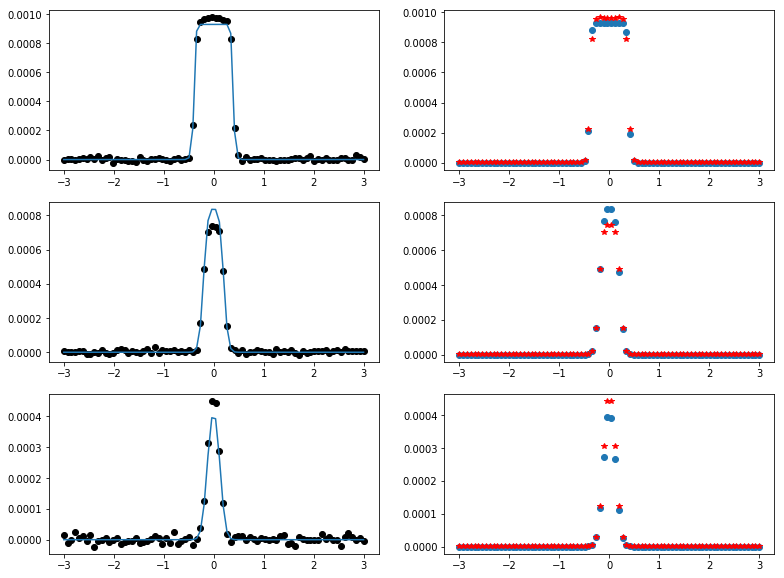

In [18]:
plt.figure(figsize=(13,10))
print 'v_turb : ',Turbvel[0,i,j]
print 'vel_cen : ',vel_cen[:,i,j]
print 'Temp : ',Temperature[:,i,j]


nu_c12 = nu0_12*(1 - vel_cen[:,i,j]/1e5)
nu_c13 = nu0_13*(1 - vel_cen[:,i,j]/1e5)
nu_c18 = nu0_18*(1 - vel_cen[:,i,j]/1e5)

model_12 = intensity(nu12, fit[0], nu_c12[0], 10**fit[2], fit[3], angle, head12, 12)
model_l12 = intensity(nu12, hpd_2_5[0], nu_c12[-2], 10**hpd_2_5[2], hpd_2_5[3], angle, head12, 12)
model_u12 = intensity(nu12, hpd_97_5[0], nu_c12[-1], 10**hpd_97_5[2], hpd_97_5[3], angle, head12, 12)

model_13 = intensity(nu13, fit[0], nu_c13[0], 10**fit[2], fit[3], angle, head13, 13)
model_l13 = intensity(nu13, hpd_2_5[0], nu_c13[-2], 10**hpd_2_5[2], hpd_2_5[3], angle, head13, 13)
model_u13 = intensity(nu13, hpd_97_5[0], nu_c13[-1], 10**hpd_97_5[2], hpd_97_5[3], angle, head13, 13)

model_18 = intensity(nu18, fit[0], nu_c18[0], 10**fit[2], fit[3], angle, head18, 18)
model_l18 = intensity(nu18, hpd_2_5[0], nu_c13[-2], 10**hpd_2_5[2], hpd_2_5[3], angle, head18, 18)
model_u18 = intensity(nu18, hpd_97_5[0], nu_c13[-1], 10**hpd_97_5[2], hpd_97_5[3], angle, head18, 18)

dv = velocities[1]-velocities[0]

plt.subplot(321)

plt.plot(velocities,data12,'ko')
plt.plot(velocities,model_12)
#plt.fill_between(velocities, model_l12, model_u12, color='0.5', alpha=0.5)

plt.subplot(322)

plt.plot(velocities,model_12,'o')
plt.plot(velocities,data_12,'r*')
#plt.fill_between(velocities, model_l12, model_u12, color='c', alpha=0.5)

plt.subplot(323)

plt.plot(velocities,data13,'ko')
plt.plot(velocities,model_13)
#plt.fill_between(velocities, model_l13, model_u13, color='0.5', alpha=0.5)

plt.subplot(324)

plt.plot(velocities,model_13,'o')
plt.plot(velocities,data_13,'r*')
#plt.fill_between(velocities, model_l13, model_u13, color='c', alpha=0.5)

plt.subplot(325)

plt.plot(velocities,data18,'ko')
plt.plot(velocities,model_18)
#plt.fill_between(velocities, model_l18, model_u18, color='0.5', alpha=0.5)

plt.subplot(326)

plt.plot(velocities,model_18,'o')
plt.plot(velocities,data_18,'r*')
#plt.fill_between(velocities, model_l18, model_u18, color='c', alpha=0.5)

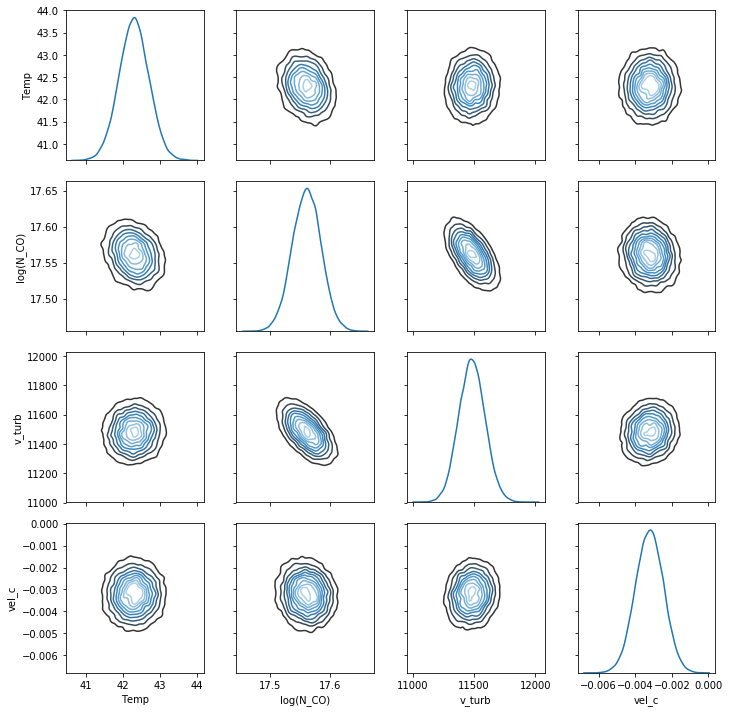

In [71]:
import seaborn as sns

import pandas as pd
df = pd.DataFrame({'Temp':trace['Temp'],'vel_c':trace['vel_c'],'log(N_CO)':trace['log(N_CO)'],'v_turb':trace['v_turb']})
g = sns.PairGrid(df,despine=False,diag_sharey=False)
g.map_lower(sns.kdeplot, cmap="Blues_d")
g.map_upper(sns.kdeplot, cmap="Blues_d")
g.map_diag(sns.kdeplot)

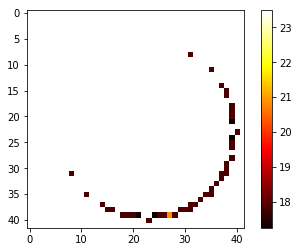

In [25]:
"""
Fits a temperature profile, turbulent velocity and column density
using three CO isotopologues lines with iminuit package.
"""
cont = False
r = 17   # radius in pixels units where to make the fit
# CO isotopologue, it could be 12,13,18
Convolve = False
Beam = 0.25                                                         #Only used if Convolve=True, size of beam in arcsec.

tag_nco = '/Users/falarcon/Desktop/Tesis/Line_fitting/test_fo/'                                 #path with the molecule input files.
g_u = 7                                                             #Degeneracy of state
Z12 = tag_nco + 'molecule_12c16o.inp'                                 #File with info of molecular transitions.
Z13 = tag_nco + 'molecule_13c16o.inp' 
Z18 = tag_nco + 'molecule_12c18o.inp' 
en12, gs12 = partition(Z12) 
en13, gs13 = partition(Z13)
en18, gs18 = partition(Z18)
incli = 0.*sp.pi/180.                                               #Inclination of disk in degrees.
path = '/Users/falarcon/Desktop/Tesis/Line_fitting/fo_pardisk/'                            # Path to FITS files to fit.
image12 = path + 'image_12co32_nodust__o0_i180.00_phi90.00_PA-24.00'  #Fits File without the .fits
image13 = path + 'image_13co32_nodust__o0_i180.00_phi90.00_PA-24.00'
image18 = path + 'image_c18o32_nodust__o0_i180.00_phi90.00_PA-24.00'
ncores = 4                                                        #Number of cores for parallel running.

print('Opening FITS images and fitting functions')

#  Isotopologue image and centroid map
cubo12, head12 = datafits(image12)
cubo13, head13 = datafits(image13)
cubo18, head18 = datafits(image18)

dnu12 = head12['CDELT3']
len_nu12 = head12['NAXIS3']
nui_12 = head12['CRVAL3']- head12['CRPIX3']*dnu12
nuf_12 = nui_12 + (len_nu12-1)*dnu12
nu12 = sp.linspace(nui_12, nuf_12, len_nu12)
nu0_12 = sp.mean(nu12)

dnu13 = head13['CDELT3']
len_nu13 = head13['NAXIS3']
nui_13 = head13['CRVAL3']- head13['CRPIX3']*dnu13
nuf_13 = nui_13 + (len_nu13-1)*dnu13
nu13 = sp.linspace(nui_13, nuf_13, len_nu13)
nu0_13 = sp.mean(nu13)

dnu18 = head18['CDELT3']
len_nu18 = head18['NAXIS3']
nui_18 = head18['CRVAL3']- head18['CRPIX3']*dnu18
nuf_18 = nui_18 + (len_nu18-1)*dnu18
nu18 = sp.linspace(nui_18, nuf_18, len_nu18)
nu0_18 = sp.mean(nu18)


#Gaussian Convolution
if False:
    resol12 = abs(head12['CDELT1'])*3600
    stdev12 = Beam12 / (2 * sp.sqrt (2 * sp.log(2)))
    stdev12 /= resol12
    x_size12 = int(8*stdev12 + 1.)

    print 'convolution with gaussian'
    print '\tbeam '+str(Beam12)+' arcsec'
    print '\tbeam '+str(stdev12)+' pixels'

    # circular Gaussian
    beam12 = Gaussian2DKernel (stddev = stdev12, x_size = x_size12, y_size = x_size12,
                             model ='integrate')
    smooth12 =  np.zeros((len_nu12, head12['NAXIS2'], head12['NAXIS1']))
    for k in range(80):
        smooth12[k, :,:] += convolve_fft(cubo12[k,:,:], beam12)
    print '\tsmoothed'
    cubo = smooth12



cubomax12 = cubo12.max()
cubomax13 = cubo13.max()
cubomax18 = cubo18.max()

stderr_12 = sp.std(cubo12)
stderr_13 = sp.std(cubo13)
stderr_18 = sp.std(cubo18)
alpha = 2.3
i0 = 0.0   # continuum guess
angle = 24.*sp.pi/180.   # PA, not used for fitting.
ndim = head12['NAXIS1']
Temperature = sp.zeros((6,ndim,ndim))
tau0 = sp.zeros((ndim,ndim))
Denscol = sp.zeros((6,ndim,ndim))
Turbvel = sp.zeros((6,ndim,ndim))
vel_cen = sp.zeros((6,ndim,ndim))
mom2 = sp.zeros((ndim,ndim))
velocities = sp.linspace(sp.around(((nu0_12-nui_12)*c*1e-5/nu0_12),1),sp.around((nu0_12-nuf_12)*c*1e-5/nu0_12),len_nu12)

def parspar(n):
    i = n/ndim
    j = n%ndim
    data_12 = cubo12[:,i,j]
    data_13 = cubo13[:,i,j]
    data_18 = cubo18[:,i,j]
    datamax = data12.max()
    noise_level = 0
    data12 = data_12+sp.random.normal(scale=noise_level,size=len(data_12))
    data13 = data_13+sp.random.normal(scale=noise_level,size=len(data_13))
    data18 = data_18+sp.random.normal(scale=noise_level,size=len(data_18))
    if (i-int(ndim/2.))**2 + (j-int(ndim/2.))**2 > r**2 or 0.4*cubomax12>datamax:
        return [None]

    print i,j
    
    datamin = max(data12.min(),0)
    data1 = data12 -data12.min()
    centroid = (nu12*(cubo12[:,i,j]-datamin)).sum()/(cubo12[:,i,j]-datamin).sum()
    centroid = 1e5*(nu0_12-centroid)/nu0_12  #Centroid guess in velocity space

    i0 = datamin
    if i0==0:
        i0=1e-10
    i0_lim=(0.5*i0,1.2*i0)


    r_ij = sp.sqrt((i-128)**2 +(j-128)**2)
    rho_ij = r_ij/sp.cos(incli)

    if rho_ij<30:
        temp_0 = 70
        tlim = (10,200)
    else:
        temp_0 = 70 * (r_ij / 30.)**(-0.5)
        tlim = (10,120)
    vels = (nu12-nu0_12)*3e5/nu0_12  #Velocities en km/s
    velg = vels[data==data.max()][0]

    noise = data[(velocities<velg-1) | (velocities>velg+1.)]
    rms = np.sqrt(sp.sum(noise**2)/float(len(noise)))

## Cont=True Fit lines considering the presence of continuum.
    if cont:
        line_model = pm.Model()
    
        with line_model:
        
            var = ['Temp','nu_c','log(N_CO)','v_turb','Continuum']

# Priors for unknown model parameters
            Temp = pm.TruncatedNormal('Temp', mu=temp_0, sd=5, lower=tlim[0], upper=tlim[1])
            nu_c = pm.TruncatedNormal('nu_c', mu=centroid, sd=abs(dnu)/10., lower=centroid-0.5*abs(dnu), upper=centroid+0.5*abs(dnu))
            NCO = pm.Uniform('log(N_CO)', lower=10, upper=24)
            v_turb = pm.Uniform('v_turb', lower=sp.sqrt(k*tlim[0]/m), upper=300000)  ## This is really broadening in velocity space, not turbulent vel.
            i_0 = pm.TruncatedNormal('Continuum', mu=i0, sd=5, lower=i0_lim[0], upper=i0_lim[1])
    
    # Expected value of outcome)
        
            predict = intensity_continuum(nu, Temp, nu_c, alpha, 10**NCO, v_turb, angle, i_0, head, iso)
    
    # Likelihood (sampling distribution) of observations
            Y_obs = pm.Normal('Y_obs', mu=predict, sd=rms, observed=data)
            step = pm.NUTS()
    
            st = {'Temp':temp_0,
                'nu_c':centroid,
                'log(N_CO)':20,
                'v_turb':20000,
                'Continuum':i0}

            trace = pm.sample(5000,tune=1000,cores=2,step=step,start=st)

            stats = pm.summary(trace)

            mean_pars = [stats['mean'][x] for x in var]
            hpd_2_5 = [stats['hpd_2.5'][x] for x in var]
            hpd_97_5 = [stats['hpd_2.5'][x] for x in var]
            var_std = [stats['sd'][x] for x in var]
            medians_pars = [sp.median(trace[x]) for x in var]
            Map = [float(pm.find_MAP(model=line_model)[x]) for x in var]
            fit = mean_pars
            model = intensity_continuum(nu, fit[0], fit[1],alpha, 10**fit[2], fit[3], angle,fit[4], head, iso)

#dust[i,j] = fit[3]*sp.exp(-tau(fit[0],nu,fit[4],fit[2],fit[1],angle, iso))*(nu/nu0)**alpha


    else:
        line_model = pm.Model()
    
        with line_model:
        
            var = ['Temp','vel_c','log(N_CO)','v_turb']
            
            # Priors for unknown model parameters
            Temp = pm.TruncatedNormal('Temp', mu=temp_0, sd=5, lower=tlim[0], upper=tlim[1])
            vel_c = pm.TruncatedNormal('vel_c', mu=centroid, sd=.4, lower=centroid-1, upper=centroid+1)
            NCO = pm.Uniform('log(N_CO)', lower=10, upper=24)
            v_turb = pm.Uniform('v_turb', lower=sp.sqrt(k*tlim[0]/m), upper=300000) ## This is really broadening in velocity space, not turbulent vel.
            
            
            nu_c12 = nu0_12*(1 - vel_c/1e5)
            nu_c13 = nu0_13*(1 - vel_c/1e5)
            nu_c18 = nu0_18*(1 - vel_c/1e5)
            # Expected value of outcome
            predict12 = intensity(nu12, Temp, nu_c12, 10**NCO, v_turb, angle, head12, 12)
            predict13 = intensity(nu13, Temp, nu_c13, 10**NCO, v_turb, angle, head13, 13)
            predict18 = intensity(nu18, Temp, nu_c18, 10**NCO, v_turb, angle, head18, 18)
            
            predict12 = intensity(nu12, Temp, nu_c12, 10**NCO, v_turb, angle, head12, 12)
            predict13 = intensity(nu13, Temp, nu_c13, 10**NCO, v_turb, angle, head13, 13)
            predict18 = intensity(nu18, Temp, nu_c18, 10**NCO, v_turb, angle, head18, 18)

            
            # Likelihood (sampling distribution) of observations
            Y_obs12 = pm.Normal('Y_obs12', mu=predict12, sd=rms, observed=data12)
            Y_obs13 = pm.Normal('Y_obs13', mu=predict13, sd=rms, observed=data13)
            Y_obs18 = pm.Normal('Y_obs18', mu=predict18, sd=rms, observed=data18)

            step = pm.NUTS()
            
            st = {'Temp':temp_0,
                'vel_c':centroid,
                'log(N_CO)':20,
                'v_turb':20000}
        
            trace = pm.sample(5000,tune=1000,cores=2,step=step,start=st)
            
            stats = pm.summary(trace)
            
            mean_pars = [stats['mean'][x] for x in var]
            hpd_2_5 = [stats['hpd_2.5'][x] for x in var]
            hpd_97_5 = [stats['hpd_2.5'][x] for x in var]
            var_std = [stats['sd'][x] for x in var]
            medians_pars = [sp.median(trace[x]) for x in var]
            Map = [float(pm.find_MAP(model=line_model)[x]) for x in var]
            fit = mean_pars

    Temperature[:,i,j] = sp.array([fit[0],var_std[0],medians_pars[0],Map[0],hpd_2_5[0],hpd_97_5[0]])
    Denscol[:,i,j] = sp.array([10**fit[2],10**fit[2]*sp.log(10)*var_std[2],10**medians_pars[2],10**Map[2],10**hpd_2_5[2],10**hpd_97_5[2]])
    Turbvel[:,i,j] = sp.sqrt(((sp.array([fit[3],var_std[3],medians_pars[3],Map[3],hpd_2_5[3],hpd_97_5[3]]))**2 - k*fit[0]/m))*1e-5
    vel_cen[:,i,j] = sp.array([fit[1],var_std[1],medians_pars[1],Map[1],hpd_2_5[1],hpd_97_5[1]])
    return [i,j,Temperature[:,i,j], Denscol[:,i,j], Turbvel[:,i,j],vel_cen[:,i,j]]


p = Pool(ncores)
todo = p.map(parspar, range(cubo[0,:,:].size))
todo = sp.array(todo)
#todo = todo[todo!=None]
for ls in todo:
    if len(ls)!=6:
        continue
    i = ls[0]
    j = ls[1]
    Temperature[i,j,:] = ls[2]
    Denscol[:,i,j] = ls[3]
    Turbvel[:,i,j] = ls[4]
    vel_cen[:,i,j] = ls[5]


# Parameter error (confidence intervals)
#errmodel= sp.array(errmodel)
#model = sp.array(model)
#model = sp.swapaxes(model, 0,1)
#model = sp.swapaxes(model,0,2)
print('Calculated Fits')
#model = sp.nan_to_num(model)
#dust = sp.nan_to_num(dust)
Denscol = sp.nan_to_num(Denscol)
Turbvel = sp.nan_to_num(Turbvel)
Temperature = sp.nan_to_num(Temperature)
vel_cen = sp.nan_to_num(vel_cen)
#tau0 = sp.nan_to_num(tau0)

if Convolve:
    Denscol = Convolv(Denscol, head12)
    Temperature = Convolv(Temperature, head12)
    Turbvel = Convolv(Turbvel, head12)
    mom2 = Convolv(mom2, head12)

#r1 = pf.PrimaryHDU(model)
r2 = pf.PrimaryHDU(Temperature)
r3 = pf.PrimaryHDU(Turbvel)
r4 = pf.PrimaryHDU(Denscol)
#r5 = pf.PrimaryHDU(errmodel)
#r6 = pf.PrimaryHDU(tau0)
r9 = pf.PrimaryHDU(mom2)
#r10 = pf.PrimaryHDU(dust)
head1 = head12
head2 = head12
head3 = head12
head4 = head12
#r1.header = head
r2.header = head1;
head1['BUNIT'] = 'K'
head2['BUNIT'] = 'cm/s'
head2['BTYPE'] = 'Velocity'
head3['BUNIT'] = 'm-2'
head3['BTYPE'] = 'Column Density'
head3['BUNIT'] = 'cm'
head4['BTYPE'] = 'Optical Depth'
r3.header = head2
r4.header = head3
#r5.header = head
#r6.header = head4
r9.header = head2
#r10.header = head

## Path where FITS files are saved.
inputimage = '/Users/falarcon/Desktop/Line_fitting/fo_pardisk/sims_' + str(iso)
out1 = inputimage + '_model.fits'
out2 = inputimage + '_Temp.fits'
out3 = inputimage + '_v_turb.fits'
out4 = inputimage + '_NCO.fits'
out6 = inputimage + '_tau_nu0.fits'
out5 = inputimage + '_errfit.fits'
out9 = inputimage + '_mom2.fits'
out10 = inputimage + '_dust.fits'
print('Writing images')
#r1.writeto(out1, clobber=True)
r2.writeto(out2, clobber=True)
r3.writeto(out3, clobber=True)
r4.writeto(out4, clobber=True)
#r5.writeto(out5, clobber=True)
#r6.writeto(out6, clobber=True)
r9.writeto(out9, clobber=True)
#r10.writeto(out10, clobber=True)
#pf.writeto(out1, model, head, clobber=True)
pf.writeto(out2, Temperature, head1, clobber=True)
pf.writeto(out3, Turbvel, head2, clobber=True)
pf.writeto(out4, Denscol, head3, clobber=True)
#pf.writeto(out5, errmodel, head, clobber=True)
pf.writeto(out9, mom2, head2, clobber=True)
#pf.writeto(out6, tau0, head4, clobber=True)
#pf.writeto(out10, dust, head, clobber=True)


